# Heart Disease

### Inleiding

Hart- en vaatziektes is een verzamennaam voor verschillende ziekten aan het het of aan de bloedvaten. Hart en vaatziektes zijn de belangrijkste doodsoorzaak in Nederland. Dertig procent van alle mensen sterft eraan. 

Ze zijn onder te verdelen in een aantal soorten:
- slechte bloedaanleg
- hartfalen
- hartritmestoornissen
- aangeboren hartziektes
- aandoenlingen aan de hartkleppen

Wat hart- en vaatziekten veroorzaakt verschilt per ziekte. Wel zijn er een aantal factoren die ervoor zorgen dat u meer kans heeft om last te krijgen van hart- en vaatziekten, namelijk: roken, overgewicht, diabetes, hoge bloeddruk en een te hoog cholesterolgehalte.

### Wat is het probleem? Wat voor labels heb je?

Het probleem is om te voorspellen of iemand een hartziekte heeft of niet op basis van een aantal features.

**Features**

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment

**Label(s)**

12 Diagnosis of heart disease (target) : Displays whether the individual is suffering from heart disease or not : 0 = absence 1 or above = present.

**Dimensies dataset**

(918, 12)

**Soorten data/features**

ints, floats en objects (strings)

### Voorspelling

**Welke classifier zal het beste zijn en waarom?**

Ik verwacht dat Logistic Regression het beste classifer voor dit probleem zal zijn, omdat er sprake is van een binaire label en een kleine dataset. Ook zou Decision Tree hier ook van pas komen, omdat de dataset gewoon klein is en deze goed met kleine datasets om kan gaan. Dan verwacht ik wel dat Random Forest Classifier het beter zal doen, aangezien deze een ensamble is van verschillende Decision Trees. Dit maakt volgensmij de kans groter dat RF het beter zal doen dan DT.

Wel is dat RF meer accuraat gericht is en Logistic Regression juist tijdgericht. Daarom kan RF het wel beter doen dan Logistic Regression. Toch zal RF wel slomer zijn.

**Welke hyperparameters zijn relevant en waarom?**

Logistic Regression: Heeft niet echt hyperparameters om te tunen. Solver zou anders wel het belangrijkste zijn. Als je de solver veranderd kun je af en toe een verschil in performance zien.

DTC: 
- n_estimators: aantal trees: zegt genoeg.
- max_depth: De diepte van een DT kan zeker uitmaken op de uitkomst (meerdere if statements om zo nauwkeurig mogelijk te zijn). 
- min_samples_leaf: Het aantal nodes in een DT kan veel invloed hebben op de efficiëntie. Meer nodes = meer splitsingen, wat meer rekenkracht kost. Toch is dit een relatief kleine dataset.

RFC:
- n_estimators
- max_depth
- min_sample_leaf
- max_features

### Methoden

**Welke preprocessing stappen zijn nodig?**

- Checken of er duplicates en/of lege cellen zijn -> nee
- Outliers eruit halen
- One-hot-encoding
- Bekijken welke features belangrijk zijn

**Welke classifiers ga je vergelijken?**
- Logistic regression
- Decision Tree Classifier
- Random Forest Tree. 

**Welke performance metric is passend?**
Er zijn zeker wel een aantal metrics hierbij passend. Één daarvan is de Recall score. Ik vind het belangrijk om te kijken of degene die getest zijn met heartdisease ook echt correct geclassificeerd zijn als 'patient met hartziekte'. Daarom wordt er geporobeerd om de recall metric zo hoog mogelijk te verkrijgen. De False Nagetives zijn dus belangrijker dan False Positives.

Formule:
Recall = (TP) / (TP + FN)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Import libraries

In [264]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from time import time

import warnings
warnings.filterwarnings("ignore")

### Data veroveren

Hieronder kun je de eerste vijf rijen van de dataset bekijken. Er is een kolom dat HeartDisease heet. Dit is onze label. Dit bestaat uit twee unieke waarden: 0 en 1. 

0 = false (geen heartdisease)

1 = true  (wel heartdisease)

In [265]:
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [266]:
# bekijk de dimensies
data.shape

(918, 12)

In [267]:
# bekijk de types van de kolommen
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

**Insights**
- Er zijn 918 rijen en 12 kolommen in de dataset
- Er zijn 5 kolommen die geen getallen zijn. Dit zijn: Sex, ChestpainType, RestingECG, ExerciseAngina en ST_Slope. Deze moeten worden veranderd naar getallen

In [268]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


**Insights**
- De meeste patienten zijn tussen de 47 en 60 jaar oud.
- Bij RestingBP is de minimale waarde 0, terwijl 25% van de goep bijvoorbeeld 120 bevat. De gemiddelde is 132. Dit kan dus een uitsmijter zijn. Dezelfde geldt voor de cholesterol-gehalte.
- FastingBS kan wel gewoon minimaal 0 zijn, aanegzien de meeste ook gewoon 0 als waarde hebben.
- Zo'n 55% van de patienten heeft hartproblemen.
- De standaardafwijking van cholelesterol-gehalte is redelijk hoog. er moet dus wel een variatie zijn.

In [269]:
data.describe(include='object').T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


**Insights**
- ChestPainType, RestingECG en ST_slope hebben meerdere unieke waardes.

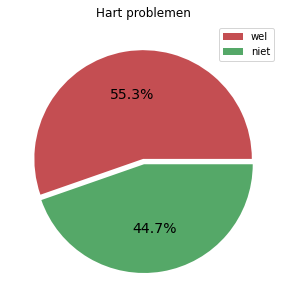

In [270]:
with_disease = data[data['HeartDisease'] == 1]['HeartDisease'].count()
without_disease = data[data['HeartDisease'] == 0]['HeartDisease'].count()

colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn. Niet dat 90% van de data wel borstkanker heeft en maar 10% niet o.i.d. Je kunt dus zien dat het 
# 40/60 verdeeld is. Dat is nog prima.
plt.figure(figsize=(5,5))
plt.pie([with_disease, without_disease], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['wel','niet'])
plt.title('Hart problemen')
plt.show()

**Insights**

55% van de kandidaten heeft hartproblemen en 45% niet. De dataset is dus prima in balans.

### Pre-processing

In [271]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [272]:
data.duplicated().sum()

0

**Insights**

- Er zijn geen gedupliceerde waarden
- Er zijn geen lege cellen


##### Categorisch -> numeriek

In [273]:
categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

data['Sex'] = data['Sex'].map({'M': 0, 'F': 1})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 0, 'N': 1})

In [274]:
columns_to_encode = ['ChestPainType','RestingECG','ST_Slope']

data = pd.get_dummies(columns=columns_to_encode, data=data)

data.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,1,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,1,160,180,0,156,1,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,0,130,283,0,98,1,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,1,138,214,0,108,0,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,0,150,195,0,122,1,0.0,0,0,0,1,0,0,1,0,0,0,1


In [275]:
data.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

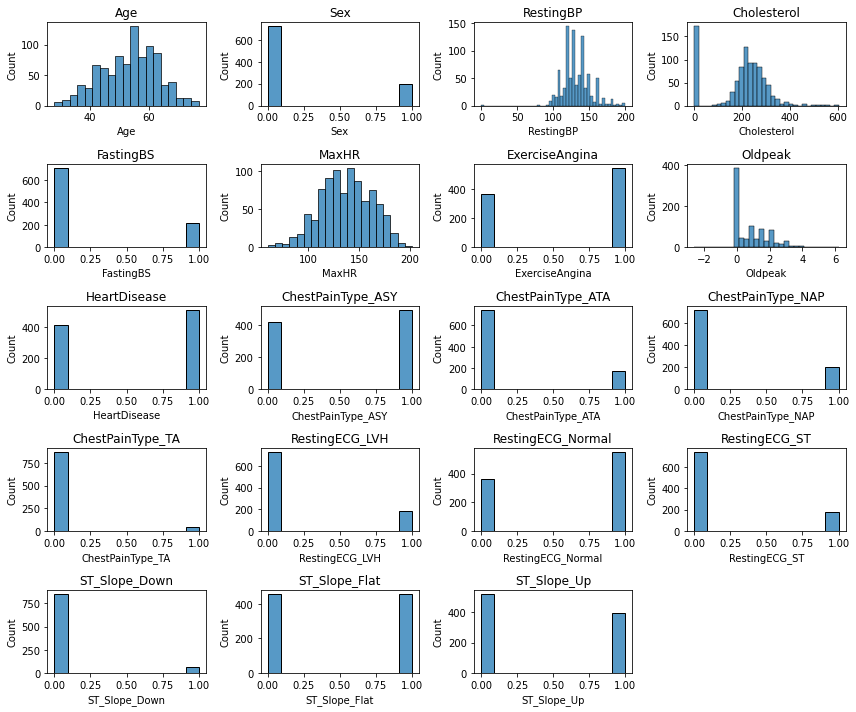

In [276]:
plt.figure(figsize=(12,10))
for idx, column in enumerate(data.columns):
    plt.subplot(5, 4, idx+1)
    sns.histplot(x=column, data=data)
    plt.title(column)
    plt.tight_layout()
plt.show()

**Insights**
- Waardes zoals Age en MaxHR zien er redelijk normaal verdeeld uit.
- Bij cholesterol zijn er heelveel 0 waardes. Dit zijn hoogstwaarschijnlijk uitsmijters, want 0 als waarde voor cholesterol is niet mogelijk.
- Er zijn veel meer mannen met hartproblemen dan vrouwen.
- OldPleak heeft een negatieve waarde. Deze kunnen niet negatief zijn.
- Er zijn zowat even veel ST_Slope_Flat bij zowel heartdiseased als niet.
- ST_Slope_Down en ChestPainType_TA zijn heel wat hoger bij degenen zonder hertziektes.

<br><br>

Om er zeker van te zijn dat RestingBP en Cholesterol uitsmijters bevat, wordt er hieronder een boxplot getekend.

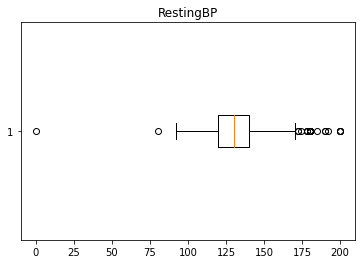

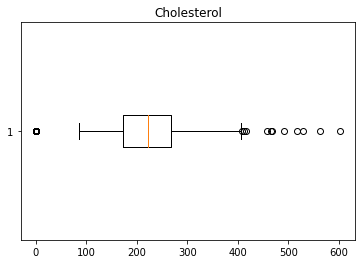

In [277]:
plt.boxplot(data['RestingBP'], vert=False)
plt.title('RestingBP')
plt.show()

plt.boxplot(data['Cholesterol'], vert=False)
plt.title('Cholesterol')
plt.show()

**Insights**
- Er zijn inderdaad uitsmijters. 
- Er is maar 1 negatieve waarde bij RestingBP (wat niet kan). Ik denk dat dit gewoon een typefout is, want de absolute waarde komt gewoon goed overeen. Deze kunnen we dus veranderen naar de abolute waarde.
- Bij cholesterol kan dit niet zomaar. Het zijn er teveel en cholesterol heeft een groot invloed. Aangezien het er te veel zijn en dat het gewoon echt uitsmijters zijn, kan de gemiddelde hier niet gebruikt voor worden. De beste optsie is dus of de mediaan of de modus te gebruiken.

Laten we beginnen met de cholesterol-gehalte. We weten dat 0 niet kan. Ik wil de 0-waardes ook niet weggooien, aangezien de dataset niet al te groot is.

In [278]:
median_cholesterol = data['Cholesterol'].median()
data["Cholesterol"].replace(0, median_cholesterol, inplace=True)
data['Cholesterol'] = data['Cholesterol'].apply(lambda x: x if x < 450 else median_cholesterol)

We hebben net geconcludeerd dat we de absolute waarde kunnen gebruiken voor Oldpeak, aangezien het maar 1 waarde is. Hoogstwaarschijnlijk is dit een typefout.

In [279]:
data.loc[data['Oldpeak'] < 0,'Oldpeak'] = 0.1 # absolute waarde van de oude oldPeak

Last but not least, de RestingBP. Hierbij kunnen we wel gewoon de gemiddelde gebruiken. Dit zal niet veel invloed hebben op de vorige gemiddelde.

In [280]:
mean_restingbp = data['RestingBP'].mean()

data["RestingBP"].replace(0, mean_restingbp, inplace=True)

### Feature selection

#### Heatmap

Eerst even de Heartdisease kolom achteraan verplaatsen, zodat we een beter inzicht krijgen

In [281]:
old_columns = data.columns.to_list()

hd_index = old_columns.index('HeartDisease')

hd = old_columns.pop(hd_index)

new_columns = [*old_columns, hd]

data = data[new_columns]

<AxesSubplot:>

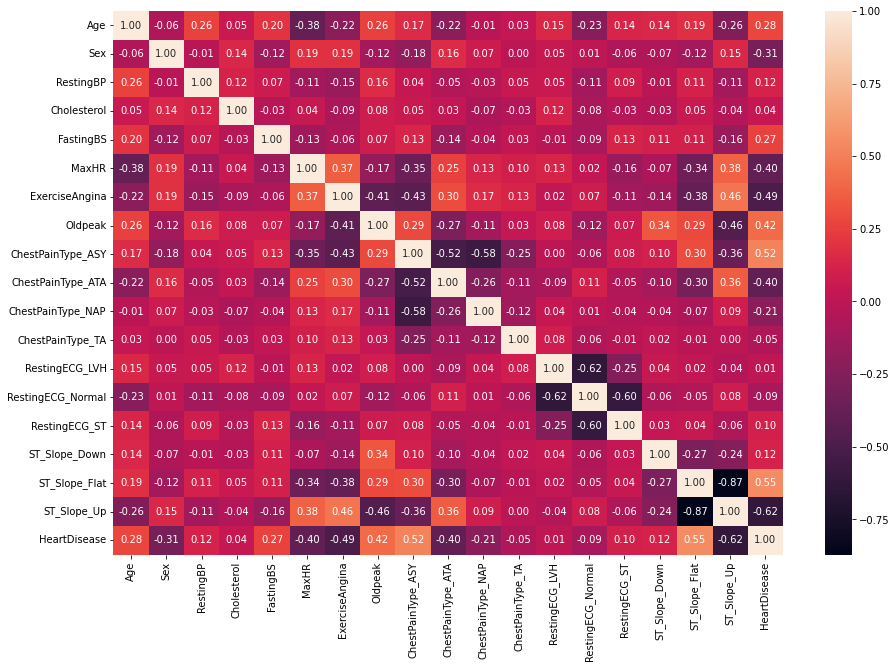

In [282]:
# Visualiseer de correlatie tabel met een heatmap
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

**Insights**

- Op eerste blik lijkt het dat MaxHR, ST_Slope_Flat en ExerciseAngina een sterk correlatie te hebben met Heartdisease.
- Kolommen zoals Cholesterol hebben volgens de heatmap weinig invloed op de label. Ook hebben deze indirect niet veel invloed op andere features

#### Statistics (T-test en Anova)

1. In plaats van correlaties tussen interval variabelen en de target variabele "satisfaction" te berekenen, kan ik t testen doen.
2. In plaats van correlaties tussen nominale variable en de target variabele "satisfaction" te berekenen, kan ik een chi square doen.
3. Als ik een nominale variabele heb, waar wel een rangorde in zit, kan ik een Mann Whitney test doen of eveneens kiezen voor een chi square.

#### T-Test

##### Kolmogorov-Smirnov

We moeten eerst bekijken of we een normale t-test of een welsch t-test moeten doen. Dit kunnen we beslissen door te kijken of de dataset normaal verdeeld is. Als dat zo is, kunnen we de normale t-test gebruiken. Zoniet, dan de welsch t-test.

Om te bepalen of de dataset normaal verdeeld is, kunnen we de kolomogoriv-smirlov test doen. 

H0: De verdeling is normaal verdeeld.

In [283]:
from scipy.stats import kstest

In [284]:
kstest(data['Age'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [285]:
kstest(data['Cholesterol'],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [286]:
kstest(data['RestingBP'],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [287]:
kstest(data['FastingBS'],'norm')

KstestResult(statistic=0.5, pvalue=9.62555011802948e-213)

**Insights**
- De kolommen hebben een pvalue lager dan 5% -> reject H0 -> niet normaal verdeeld

Conclusie:

Gebruik Welsch t-test.

<br>
De t-test van scipy geeft niet heel veel informatie. We missen informatie over de effect size. Pearson R kan ons hierbij helpen. Daarom gebruiken we researchpy. Dit geeft al wat meer inzicht



1. In plaats van correlaties tussen interval variabelen en de target variabele "satisfaction" te berekenen, kan ik t testen doen.
2. In plaats van correlaties tussen nominale variable en de target variabele "satisfaction" te berekenen, kan ik een chi square doen.
3. Als ik een nominale variabele heb, waar wel een rangorde in zit, kan ik een Mann Whitney test doen of eveneens kiezen voor een chi square.

categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

interval_feautures = ['Age', 'RestingBP,', 'Cholesterol', 'FastingBS', 'MaxHR', 'OldPeak']

In [288]:
import researchpy as rp

In [289]:
wel = data[data['HeartDisease'] == 1]
geen = data[data['HeartDisease'] == 0]

#### Interval kolommen

<mark>Cholesterol</Mark>

In [290]:
rp.ttest(group1=wel['Cholesterol'], group2=geen['Cholesterol'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  239.728346  45.881902  2.035680  235.728939  243.727754
 1      niet  410.0  235.997561  49.195409  2.429588  231.221523  240.773599
 2  combined  918.0  238.062092  47.400535  1.564451  234.991772  241.132411,
                Welch's t-test   results
 0  Difference (wel - niet) =     3.7308
 1       Degrees of freedom =   849.6912
 2                        t =     1.1770
 3    Two side test p value =     0.2395
 4   Difference < 0 p value =     0.8802
 5   Difference > 0 p value =     0.1198
 6                Cohen's d =     0.0787
 7                Hedge's g =     0.0787
 8            Glass's delta =     0.0813
 9              Pearson's r =     0.0403)

**Insights**
- p value > 5%
- Ho wordt behouden, dus er is geen significant verschil
- Pearsons r is zeer zwak
- weggooien

<mark>Age</mark>

In [291]:
rp.ttest(group1=wel['Age'], group2=geen['Age'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0       wel  508.0  55.899606  8.727056  0.387200  55.138891  56.660321
 1      niet  410.0  50.551220  9.444915  0.466451  49.634279  51.468160
 2  combined  918.0  53.510893  9.432617  0.311323  52.899905  54.121881,
                Welch's t-test   results
 0  Difference (wel - niet) =     5.3484
 1       Degrees of freedom =   845.5957
 2                        t =     8.8225
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.5907
 7                Hedge's g =     0.5902
 8            Glass's delta =     0.6129
 9              Pearson's r =     0.2903)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk sterk
- behouden

<mark>RestingBP</mark>

In [292]:
rp.ttest(group1=wel['RestingBP'], group2=geen['RestingBP'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  134.445662  18.910339  0.839011  132.797297  136.094028
 1      niet  410.0  130.180488  16.499585  0.814856  128.578659  131.782317
 2  combined  918.0  132.540737  17.989932  0.593756  131.375458  133.706016,
                Welch's t-test   results
 0  Difference (wel - niet) =     4.2652
 1       Degrees of freedom =   912.4704
 2                        t =     3.6467
 3    Two side test p value =     0.0003
 4   Difference < 0 p value =     0.9999
 5   Difference > 0 p value =     0.0001
 6                Cohen's d =     0.2386
 7                Hedge's g =     0.2384
 8            Glass's delta =     0.2255
 9              Pearson's r =     0.1199)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk zwak
- weggooien

<mark>FastingBS</mark>

In [293]:
rp.ttest(group1=wel['FastingBS'], group2=geen['FastingBS'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       wel  508.0  0.334646  0.472332  0.020956   0.293474  0.375818
 1      niet  410.0  0.107317  0.309894  0.015305   0.077232  0.137403
 2  combined  918.0  0.233115  0.423046  0.013963   0.205713  0.260518,
                Welch's t-test   results
 0  Difference (wel - niet) =     0.2273
 1       Degrees of freedom =   882.9740
 2                        t =     8.7603
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.5573
 7                Hedge's g =     0.5569
 8            Glass's delta =     0.4813
 9              Pearson's r =     0.2828)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is redelijk sterk
- behouden

<mark>MaxHR</mark>

In [294]:
rp.ttest(group1=wel['MaxHR'], group2=geen['MaxHR'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N        Mean         SD        SE   95% Conf.    Interval
 0       wel  508.0  127.655512  23.386923  1.037627  125.616934  129.694090
 1      niet  410.0  148.151220  23.288067  1.150116  145.890344  150.412095
 2  combined  918.0  136.809368  25.460334  0.840316  135.160202  138.458534,
                Welch's t-test   results
 0  Difference (wel - niet) =   -20.4957
 1       Degrees of freedom =   879.0415
 2                        t =   -13.2315
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     0.0000
 5   Difference > 0 p value =     1.0000
 6                Cohen's d =    -0.8780
 7                Hedge's g =    -0.8773
 8            Glass's delta =    -0.8764
 9              Pearson's r =     0.4075)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is sterk
- behouden

<mark>Oldpeak</mark>

In [295]:
rp.ttest(group1=wel['Oldpeak'], group2=geen['Oldpeak'], group1_name='wel', group2_name='niet', equal_variances=False)

(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       wel  508.0  1.297638  1.110269  0.049260   1.200859  1.394417
 1      niet  410.0  0.413415  0.694012  0.034275   0.346038  0.480791
 2  combined  918.0  0.902723  1.043944  0.034455   0.835103  0.970344,
                Welch's t-test   results
 0  Difference (wel - niet) =     0.8842
 1       Degrees of freedom =   866.9220
 2                        t =    14.7343
 3    Two side test p value =     0.0000
 4   Difference < 0 p value =     1.0000
 5   Difference > 0 p value =     0.0000
 6                Cohen's d =     0.9334
 7                Hedge's g =     0.9327
 8            Glass's delta =     0.7964
 9              Pearson's r =     0.4475)

**Insights**
- p value < 5%
- Ho wordt verworpen, dus er is een significant verschil
- Pearsons r is sterk
- behouden

##### conclusie

- Age, FastingBS, Oldpeak en MaxHR behouden
- Cholesterol weggooien

#### Nominale kolommen

<mark>Sex<mark>

In [296]:
_, result = rp.crosstab(data['HeartDisease'], data['Sex'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,85.6463
1,p-value =,0.0000
2,Cramer's phi =,0.3054


**Insights**
- p-value < 0.5 -> H0 wordt verworpen, er is dus een significant verschil
- Cramers phi is redelijk sterk
- behouden

<mark>ExerciseAngina</mark>

In [297]:
_, result = rp.crosstab(data['HeartDisease'], data['ExerciseAngina'], test= "chi-square")

result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,224.2809
1,p-value =,0.0000
2,Cramer's phi =,0.4943


**Insights**
- p-value < 0.5 -> H0 wordt verworpen, er is dus een significant verschil
- Cramers phi is redelijk sterk
- behouden

<mark>ChestPainType</mark>

In [298]:
_, result = rp.crosstab(data['HeartDisease'], data['ChestPainType_ASY'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,245.1022
1,p-value =,0.0000
2,Cramer's phi =,0.5167


In [299]:
_, result = rp.crosstab(data['HeartDisease'], data['ChestPainType_ATA'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,148.2964
1,p-value =,0.0000
2,Cramer's phi =,0.4019


In [300]:
_, result = rp.crosstab(data['HeartDisease'], data['ChestPainType_TA'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,2.7558
1,p-value =,0.0969
2,Cramer's phi =,0.0548


In [301]:
_, result = rp.crosstab(data['HeartDisease'], data['ChestPainType_NAP'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,41.6345
1,p-value =,0.0000
2,Cramer's phi =,0.2130


**Insights**
- p-value van ChestPainType_TA > 0.5 -> H0 wordt behouden, er is dus geen significant verschil -> weggooien
- De rest behouden

<mark>RestingECG</mark>

In [302]:
_, result = rp.crosstab(data['HeartDisease'], data['RestingECG_LVH'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,0.1045
1,p-value =,0.7465
2,Cramer's phi =,0.0107


In [303]:
_, result = rp.crosstab(data['HeartDisease'], data['RestingECG_Normal'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,7.6992
1,p-value =,0.0055
2,Cramer's phi =,0.0916


In [304]:
_, result = rp.crosstab(data['HeartDisease'], data['RestingECG_ST'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,9.6499
1,p-value =,0.0019
2,Cramer's phi =,0.1025


**Insights**
- P-values > 0.05 of Crampers phi te klein
- Alles verwijderen

In [305]:
_, result = rp.crosstab(data['HeartDisease'], data['ST_Slope_Down'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,13.7817
1,p-value =,0.0002
2,Cramer's phi =,0.1225


In [306]:
_, result = rp.crosstab(data['HeartDisease'], data['ST_Slope_Flat'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,281.8848
1,p-value =,0.0000
2,Cramer's phi =,0.5541


In [307]:
_, result = rp.crosstab(data['HeartDisease'], data['ST_Slope_Up'], test= "chi-square")
result

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,355.3471
1,p-value =,0.0000
2,Cramer's phi =,0.6222


**Insights**

- P-value van St_Slope_Down < 0.05, maar de cramers phi is te klein -> weggooisen
- Rest behouden


Stel nu dat we een target variable hebben met 3 categorieen, bijvoorbeeld we willen voorspellen welke Class iemand vliegt. We willen weten of leeftijd van belang is om te voorspellen welke Class iemand vliegt. Een correlatie is mogelijk, maar is afhankelijk welke klasse welk cijfer krijgt. Bij klasse kun je nog een rangorde voorstellen, maar stel voor dat je religie van de respondent wil voorspellen, dan is een correlatie een rare maat. De oplossing: ANOVA

In [308]:
from scipy.stats import f_oneway
f_oneway(data['Age'][data['ChestPainType_ASY']],
               data['Age'][data['ChestPainType_ATA']],
               data['Age'][data['ChestPainType_TA']],
               data['Age'][data['ChestPainType_NAP']])

F_onewayResult(statistic=253.63862090396984, pvalue=1.432951894151375e-149)

In [309]:
f_oneway(data['Age'], data['ChestPainType_ATA'], data['HeartDisease'])

F_onewayResult(statistic=29005.86357926783, pvalue=0.0)

In [310]:
#Als er een significant verschil is tussen de drie groepen, weten we nog niet welke groepen verschillen
#t toetsen moeten dan duidelijkheid brengen, maar we hebben dan een correctie nodig
# We kiezen hier voor Tukey's correctie

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(data['Age'], data['ChestPainType_ATA'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.2592,0.0,-6.7848,-3.7337,True


In [311]:
#Een andere veelgebruikte post hoc test is de t test met Bonferroni correctie
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

comp = mc.MultiComparison(data['Age'], data['ChestPainType_ATA'])
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")

tbl

group1,group2,stat,pval,pval_corr,reject
0,1,6.7659,0.0,0.0,True


verwijder onnodige kolommen

In [327]:
data.drop(columns=['Cholesterol', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST'], axis=1)

,Age,Sex,RestingBP,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,0,140.0,0,172,1,0.0,0,1,0,0,0,1,0
1,49,1,160.0,0,156,1,1.0,0,0,1,0,1,0,1
2,37,0,130.0,0,98,1,0.0,0,1,0,0,0,1,0
3,48,1,138.0,0,108,0,1.5,1,0,0,0,1,0,1
4,54,0,150.0,0,122,1,0.0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,110.0,0,132,1,1.2,0,0,0,0,1,0,1
914,68,0,144.0,1,141,1,3.4,1,0,0,0,1,0,1
915,57,0,130.0,0,115,0,1.2,1,0,0,0,1,0,1
916,57,1,130.0,0,174,1,0.0,0,1,0,0,1,0,1


Split data

In [328]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [383]:
import scipy.stats as stats

zscores = stats.zscore(X_train).values

print(zscores[0])

[ 0.9700116  -0.51740017  0.3390158  -0.47372135  1.83549656 -0.32451998
 -1.20277457  0.30726655 -1.10341409  2.0969165  -0.51740017 -0.24007684
 -0.49829642 -1.24799491  2.05077394 -0.26155954  0.98110491 -0.86224587]


In [382]:
has_higher_than_3 = False

for i in zscores:
    if all(y <= 3 for y in i) is False:
        has_higher_than_3 = True


has_higher_than_3

True

**Insights**
- Er zijn zscores die groter zijn dan 3. De drie betekent dat meer dan 99% van de waardes binnen 3 standaarddeviaties valt van het gemiddelde. Als het boven de 3 is, zou dit ongebruikelijk zijn, wat betekent dat er misschien outliers zouden zijn.

#### Classifiers

Met behulp van een aantal ML classifiers wordt er bepaald of iemand een hartziekte kan hebben of niet. Er worden drie verschillende modellen getrained: 
- Logistic regression
- Decision Tree Classifier
- Random Forest Tree. 


Bij hartfalen diagnotiseren is het belangrijk om te kijken of degene die getest is, ook echt correct geclassificeerd is als 'hartziekte'. Daarom wordt er geporobeerd om de recall metric zo hoog mogelijk te verkrijgen. De False Nagetives zijn dus belangrijker dan False Positives.

Formule:
Recall = (TP) / (TP + FN)

#### Logistic Regression
We gebruiken Gridsearch om de Logistic Regressor te optimaliseren. Door brute force worden de beste parameters ervoor gevonden.

In [356]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_values = {'C': [0.01, 0.1,1,10,100], 'solver': ['lbfgs', 'liblinear', 'sag','newton-cg']}

glr = GridSearchCV(LogisticRegression(random_state=11), grid_values, cv=5, scoring='recall')

glr.fit(X_train, y_train)

glr.best_params_

{'C': 0.1, 'solver': 'newton-cg'}

In [359]:
start = time()
lr = LogisticRegression(random_state=11, C=0.1)

lr.fit(X_train, y_train)

end = time()

lr_train_time = end - start

#### DecisionTreeClassifier

Ook hier wordt er met GridSearch geprobeerd om de optimale paramters te kiezen voor DesicionTreeClassifier

In [256]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth':[*[i for i in range(1, 20)], 30,40,50,70,90,100], 'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

clf = GridSearchCV(DecisionTreeClassifier(random_state=11), tree_params, cv=7, scoring='recall')

clf.fit(X_train, y_train)   

clf.best_params_

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}

**Insights**

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2} zijn dus de optimale parameters. Zelf had ik een grotere max_depth verwacht.

In [330]:
start = time()

dtc = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=5, min_samples_split=2, random_state=11)

dtc.fit(X_train, y_train)

end = time()

dt_train_time = end - start

#### RandomForestClassifier

Ik heb geprobeerd om de GridSearchCV te gebruiken bij de RFC, maar dit duurde enorm lang. Daarom leek het handig om eerst een Randomized Search te doen. M.b.v. de RandomizedSearchCV krijg ik een heldere beeld over de paramters.

In [258]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import random


# Number of trees in random forest
n_estimators = [random.randint(1, 200) for _ in range (1, 50)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [*[i for i in range(1, 20)], 30,40,50,70,90,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rrfc = RandomizedSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=7, n_jobs=-1, scoring='recall')

rrfc.fit(X_train, y_train)

rrfc.best_estimator_

RandomForestClassifier(max_depth=40, n_estimators=155, random_state=11)

Nu doen we een Gridsearch met heel wat minder parameters, aangezien we ongeveer al weten wat ongeveer de beste parameters zijn.

In [259]:
# Number of trees in random forest
n_estimators = [i for i in range(153,157)]
# Maximum number of levels in tree
max_depth = [39,40,41]
# Minimum number of samples required to be a leaf node
min_sample_split = [2,3,4]
min_sample_leaf = [3,4,5]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                # 'min_samples_leaf': min_sample_leaf,
                # 'min_samples_split': min_sample_split,
                'max_features': ['sqrt']}

grfc = GridSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=7, scoring='recall')

grfc.fit(X_train, y_train)

grfc.best_estimator_
    

RandomForestClassifier(max_depth=39, max_features='sqrt', n_estimators=153,
                       random_state=11)

In [371]:
start = time()
rfc = RandomForestClassifier(max_depth=39, max_features='sqrt', n_estimators=153, random_state=11)
rfc.fit(X_train, y_train)

end = time()

rf_train_time = end - start

## Resultaten

##### Recall score

In [332]:
from sklearn.metrics import confusion_matrix

def get_scores(model):
    pred = model.predict(X_train)
    recall_train = recall_score(y_train, pred)
    pred = model.predict(X_test)
    recall_test = recall_score(y_test, pred)

    print(confusion_matrix(y_test, pred))
    print('-----------')

    return {'train': recall_train, 'test': recall_test}
    

In [372]:
lr_scores = get_scores(lr)
dtc_scores = get_scores(dtc)
rfc_scores = get_scores(rfc)


[[72 10]
 [11 91]]
-----------
[[57 25]
 [11 91]]
-----------
[[71 11]
 [ 7 95]]
-----------


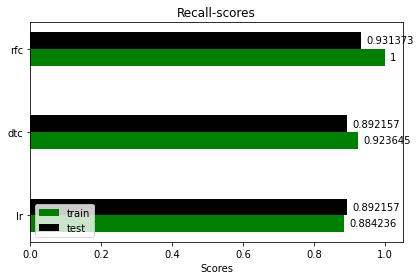

In [373]:
import numpy as np

train = [lr_scores['train'], dtc_scores['train'], rfc_scores['train']]
test = [lr_scores['test'], dtc_scores['test'], rfc_scores['test']]

models = ('lr', 'dtc', 'rfc')

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
train_bars = ax.barh(x - width/2, train, width, label='train', color='g')
test_bars = ax.barh(x + width/2, test, width, label='test', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Recall-scores')
ax.set_yticks(x, models)
ax.legend(loc="lower left")

ax.bar_label(train_bars, padding=5)
ax.bar_label(test_bars, padding=5)

fig.tight_layout()

plt.show()

**Insights**
- LR: De test doet het beter dan de train?? Dat is gek.
- DT: Dit ziet er goed uit. Geen sprake van over- of underfitting
- RFC: Klein beetje overfitting?

Door een aantal hyperparameters van RFC te wijzigen en te verwijderen, hebben we de score kunnen verbeteren van 0.89 naar 0.91. Dit heeft meteen ook de overfitting probleem opgelost:

##### ROC-curve

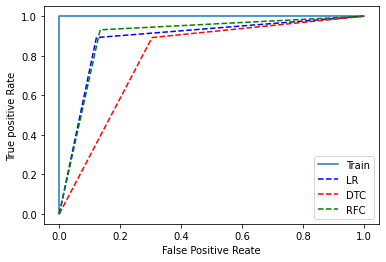

In [363]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_pred = lr.predict(X_test)
dtc_pred = dtc.predict(X_test)
rfc_pred = rfc.predict(X_test)


auc = roc_auc_score(y_test, lr_pred)

train_fpr, train_tpr, _ = roc_curve(y_test, y_test)

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
dtc_fpr, dtc_tpr, _ = roc_curve(y_test, dtc_pred)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_pred)

plt.plot()
plt.plot(train_fpr, train_tpr)
plt.plot(lr_fpr, lr_tpr, 'b--')
plt.plot(dtc_fpr, dtc_tpr, linestyle='--', color='red')
plt.plot(rfc_fpr, rfc_tpr, linestyle='--', color='green')
plt.legend(['Train', 'LR', 'DTC', 'RFC'])
plt.xlabel('False Positive Reate')
plt.ylabel('True positive Rate')

plt.show()

**Insights**
- Random Forst Classifier komt het dichtst bij de train rate. Wat je wilt hebben is dat je test lijn zo links boven mogelijk is. De oppervlakte onder de lijn moet zo groot mogelijk zijn. De RFC doet daat het best in. Dit zegt dus dat deze het minste False Positive heeft met hoogste True Positive Rate.

##### Parameters

Eerst had ik zelf met random parameters de modellen getest. De Recall-score bleef rond 0.82-0.86 zweven. Voor iedere model veranderde ik bijvoorbeeld de n_estimations, of max_depth etc. Uiteindelijk bedacht ik me dat we hier heel goed GridSearch kunnen toepassen. We kunnen zo heel snel de optimale parameters vinden.

Met behulp van RandomSearch en Gridsearch is er geprobeerd om de optimale parameters te vinden voor elke model. Met Random Forest Classifier heb ik een RandomSearch gedaan, aangezien het met GridSearch alleen te lang duurde. Maar de naam zegt het al, het is random. Hoogstwaarschijnlijk heb ik ook niet de optimale parameters ervoor gevonden.

|                          | Recall | Recall met beste parameters| 
|--------------------------|--------|----------------------------|
| Logistic Regression      | 0.88   | 0.89                       |
| Decision Tree            | 0.75   | 0.87                       | 
| Random Forest Classifier | 0.86   | 0.93                       |

#### Gebruik alle featuers

Bij het gebruik van alle features, verschilt het niet echt veel met het gebruik van belangrijkste features. Toch heb ik alleen maar de features boven de 0.2 correlatie meegenomen. Misschein zou het verschillen als ik minder features meenam. 

##### Tijd

In [374]:
print(f"LR train tijd: {lr_train_time}")
print(f"DTC train tijd: {dt_train_time}")
print(f"RFC train tijd: {rf_train_time}")

LR train tijd: 0.055236101150512695
DTC train tijd: 0.002457141876220703
RFC train tijd: 0.13824987411499023


**Insights**
- Decision Tree Classifier is het snelst
- Random Forest Classifier is het traagst

### Conclusie

De beste classifier komt volgens dit onderzoek op RFC. Zelf zat ik te twijfelen over Random Forest Classifier en Logistic Regression. Ik wist wel dat RFC hier goed bij zou passen, alleen had ik ook het voermoede dat Logistic Regression misschien beter zou werken. Ik weet zeker dat ik de optimale parameters niet heb meegegeven (heb het wel zo goed mogelijk geprobeerd).  Met betere parameters verwacht ik zelfs dat RFC het nog beter zou kunnen doen.

Random Forest Classifier heeft wel de minste False Positives tegenover de True Positives. Dit geeft aan dat deze model bij dit probleem minder fouten maakt.

Door de kolommen Cholesterol en RestingECG uit de dataset te gooien, is zowel de recall score van RFC ietsjes verhoogd. De andere twee zijn zowat dezelfde gebleven. Is het het waard om de kolommen te verwijderen? meh. Je ziet niet echt veel verschil. Toch telt elke procent.

Qua tijd is Decision Tree het snelst. Hier ben ik wel verbaast over, aangezien LR juist sneller hoort te zijn. Toch denk ik dat dit gewoon te maken heeft met het feit data de dataset klein is. Bij grotere datasets denk ik wel dat LR sneller zal zijn. Dat RFC het traagst is, is wel duidelijk.

**Hoe kan je het verbeteren?**

- Uitschieters eruit halen. Er zijn sowieso nog uitschieters.
- cross_validation toepassen. 
- Ik heb ook bijvoorbeeld bij cholesterol de 0 waardes vervangen met de mediaan. Misschien zijn andere methodes handiger. Dit zou te testen vallen.
- Last but not least, de RFC moeten we vaker runnen. Het is totaal gerandomized. Zo kwam een max_depth uit op 5, maar misschien zou een ander beter zijn geweest, die niet in de search voorbij kwam.

Ook heb ik een aantal paramters niet gebruikt. Misschien zouden die parameters wel van belang kunnen zijn met een combinatie van andere parameters. Zo heb ik bijvoorbeeld bij Logistic Regression de solver 'saga' niet gebruikt. Samen met een penalty van 'l2', kwam de recall op 100%. Dat is mooi! Maar waarom heb ik die er dan niet bijgezet? Nou, de accuracy van de model werd maar 50%... De true positives werd altijd 0! Hé! Daar hebben we helemaal niks aan! Zo zijn er wat aantal paramters die de accuracy heel erg omlaag halen, terwijl de recall score juist goed is. Daarom heb ik deze er express uitgehaald. 

Al met al, ik heb mooie resultaten bereikt met deze modellen. Een recall-score van 92% is niet niets.

### Bronnen
- https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
- https://researchpy.readthedocs.io/en/latest/ttest_documentation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
- https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832#:~:text=StandardScaler%20removes%20the%20mean%20and,standard%20deviation%20of%20each%20feature.
- https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python
- https://stackoverflow.com/questions/20229822/check-if-all-values-in-list-are-greater-than-a-certain-number
- https://datagy.io/python-z-score/